## Conexión a la API Cellphonedataset

La idea inicial del proyecto era hacer un pequeño recomendador de smartphones en base a una serie de sencillas preguntas. Para ello se ha investigado diferentes APIs, llegando a la conclusión de que no existen, o son muy difíciles de encontrar APIs que contengan bases de datos de Smartphone de forma actualizada y gratuita.

No obstante, se encontraron dos APIs que podrían ser útiles para obtener información relevante de smartphones:
- **Cellphonedataset:** Se trata de una API de fácil consulta con la desventaja de no actualizarse desde 2017 y no tener unos campos de fácil manejo.
- **PhoneDB:** Está API en la teoría parece muy potente y completa. Pero en la práctica ha sido muy difícil conectarse, consiguiendo solo que la conexión funcionara en un mock server, de donde solo se extraía el primer dispositivo. Tras ponerme en contacto con la empresa que lleva esta API, he llegado a la conclusión de que para poder acceder a la base de datos completas es necesario pasar por caja.

Por estos motivos se ha elegido la API Cellphonedataset, ya que su conexión es sencilla y la complejidad de sus campos abre la puerta a hacer un ejercicio de limpieza sobre los mismos, donde poder aplicar los conocimientos adquiridos. Es decir, usaremos esta API para descargar toda su base de datos, seleccionando los campos que más nos interesen y trabajaremos sobre algunos campos para conseguir extraer información útil de esta base de datos.
También se valoró hacer web scrapping de páginas web como https://phonedb.net/ , https://www.gsmarena.com/search.php3? , https://phonesdata.com/es/ . Decidiendo finalmente hacer uso de la API comentada.


## Índice
1. [Librerías](#librerias)
2. [Conexión](#Conexion)
3. [Creación dataframe](#dataframe)
4. [¿Cuántos dispositivos salieron al mercado por año?](#q1)
5. [¿Cuál fue la marca que más dispositivos saco al mercado en 2010?](#q2)
6. [Top 5 marcas por número de dispositivos](#q3)
7. [¿Dispositivo con más RAM?](#q4)

<a id="librerias"></a>
### Librerías

In [1]:
# Librerías a importar
import json
import urllib
import requests
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import re
plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot
# Sentencias de pandas para mostrar un mayor número de filas y columnas
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

<a id="conexion"></a>
### Conexión a **Cellphonedataset**

In [2]:
# Url de la API incluendo un limite elevado para decargarla por completo (por defecto el limite es 100)

limite = '?limit=10000' #la base de datos contiene 8.634 dispositivos
url = 'https://parseapi.back4app.com/classes/Cellphonedataset_Dataset_Cell_Phones_Model_Brand' + limite
headers = {
    'X-Parse-Application-Id': 'E9vFqvnlEr60GAHXEGArs4T2PIlQTTCS5wOvwVmX', # This is your app's application id
    'X-Parse-REST-API-Key': 'cFUjWpU2ePiHiVQ3XYEXftjCR9S2RTaTJvPgyP2M' # This is your app's REST API key
          }
r = requests.get(url, headers=headers) # Here you have the data that you need
js = json.loads(r.text)


# Observamos los datos que nos ofrece
js['results'][:2]

[{'objectId': 'pGAENEHVp2',
  'Model': '_3',
  'Brand': 'Nokia',
  'Network': 'GSM / HSPA / LTE',
  'TwoG': 'GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (dual-SIM model only)',
  'ThreeG': 'HSDPA 850 / 900 / 1900 / 2100',
  'FourG': 'LTE band 1(2100)| 3(1800)| 5(850)| 7(2600)| 8(900)| 20(800)| 28(700)| 38(2600)| 40(2300)',
  'Network_Speed': 'HSPA 42.2/5.76 Mbps  LTE Cat4 150/50 Mbps',
  'GPRS': 'Yes',
  'EDGE': 'Yes',
  'Announced': '2017  February',
  'Status': 'Available. Released 2017  June',
  'Dimensions': '143.4 x 71.4 x 8.5 mm (5.65 x 2.81 x 0.33 in)',
  'field13': '_',
  'SIM': 'Single SIM or Dual SIM',
  'Display_type': 'IPS LCD capacitive touchscreen  16M colors',
  'Display_resolution': '5.0 inches (~67.3% screen-to-body ratio)',
  'Display_size': '720 x 1280 pixels (~294 ppi pixel density)',
  'Operating_System': 'Android 7.0 (Nougat)',
  'CPU': 'Quad-core 1.4 GHz Cortex-A53',
  'Chipset': 'Mediatek MT6737',
  'GPU': 'Mali-T720MP1',
  'Memory_card': 'microSD  up to 256 GB'

Vemos que cada dispositivo trae un número de items diferente. Vamos a tratar de ver el listado completo de items distintos para ver cuales nos interesan.

In [3]:
all_keys = set().union(*(d.keys() for d in js['results']))
all_keys

{'Announced',
 'Audio_jack',
 'Battery',
 'Bluetooth',
 'Brand',
 'CPU',
 'Cell_Phone_Brands',
 'Cell_Phone_Models',
 'Chipset',
 'Colors',
 'Dimensions',
 'Display_resolution',
 'Display_size',
 'Display_type',
 'EDGE',
 'FourG',
 'GPRS',
 'GPS',
 'GPU',
 'Internal_memory',
 'Loud_speaker',
 'Memory_card',
 'Model',
 'NFC',
 'Network',
 'Network_Speed',
 'Operating_System',
 'Primary_camera',
 'RAM',
 'Radio',
 'SIM',
 'Secondary_camera',
 'Sensors',
 'Status',
 'ThreeG',
 'TwoG',
 'USB',
 'WLAN',
 'createdAt',
 'field13',
 'field38',
 'objectId',
 'updatedAt'}

<a id="dataframe"></a>
### Creación dataframe
Una vez identificados los campos que nos interesan, procedemos a crear un dataframe de pandas con los atributos que nos interesan

In [4]:
# Creamos listas vacías de los campos que queremos
Device_id = []
Brand = []
Model = []
Announced = []
Status = []
Battery = []
CPU = []
Chipset = []
Dimensions = []
Display_resolution = []
Display_size = []
Display_type = []
Internal_memory = []
NFC = []
Operating_System = []
Primary_camera = []
RAM = []

# Creamos una lista de nuestras listas
var = [Device_id, Brand, Model, Announced, Status, Battery, CPU,
       Chipset, Dimensions, Display_resolution,
       Display_size, Display_type, Internal_memory,
       NFC, Operating_System, Primary_camera, RAM]

# Creamos una lista de strings con las keys de las que extraeremos el contenido
var_str = ['objectId', 'Brand', 'Model', 'Announced', 'Status', 'Battery',
           'CPU', 'Chipset', 'Dimensions', 'Display_resolution',
           'Display_size', 'Display_type', 'Internal_memory',
           'NFC', 'Operating_System', 'Primary_camera', 'RAM']


# Puesto que no todos los dispositivos tienen todos los atributos usaremos un try except para evitar el error
# En el caso de que no contenga el atributo dejaremos el campo vacio
for el in js['results']:
    for x, y in zip(var, var_str):
        try:
            x.append(el[y])
        except:
            x.append('')    

# Creamos el dataframe de pandas
df = pd.DataFrame({'Device_id': Device_id, 'Brand': Brand, 'Model': Model,
                   'Announced': Announced, 'Status': Status, 'Battery': Battery,
                   'CPU': CPU, 'Chipset': Chipset,
                   'Dimensions': Dimensions, 'Display_resolution': Display_resolution,
                   'Display_size': Display_size, 'Display_type': Display_type, 
                   'Internal_memory': Internal_memory, 'NFC': NFC,
                   'Operating_System': Operating_System, 'Primary_camera': Primary_camera,
                   'RAM': RAM})
df.head()

,Device_id,Brand,Model,Announced,Status,Battery,CPU,Chipset,Dimensions,Display_resolution,Display_size,Display_type,Internal_memory,NFC,Operating_System,Primary_camera,RAM
0,pGAENEHVp2,Nokia,_3,2017 February,Available. Released 2017 June,Non-removable Li-Ion 2630 mAh battery,Quad-core 1.4 GHz Cortex-A53,Mediatek MT6737,143.4 x 71.4 x 8.5 mm (5.65 x 2.81 x 0.33 in),5.0 inches (~67.3% screen-to-body ratio),720 x 1280 pixels (~294 ppi pixel density),IPS LCD capacitive touchscreen 16M colors,16 GB,Yes,Android 7.0 (Nougat),8 MP| f/2.0| autofocus| LED flash|,2 GB RAM
1,tzhPycsk7Z,Philips,_160,2005 September,Discontinued,Removable Li-Ion 720 mAh battery,,,103 x 47.5 x 18.7 mm| 89 cc (4.06 x 1.87 x 0.7...,,101 x 80 pixels| 5 lines,STN monochrome graphics,4 MB,,,,
2,E72HYPBi8V,OnePlus,_5,2017 June,Available. Released 2017 June,Non-removable Li-Po 3300 mAh battery,Octa-core (4x2.45 GHz Kryo & 4x1.9 GHz Kryo),Qualcomm MSM8998 Snapdragon 835,154.2 x 74.1 x 7.3 mm (6.07 x 2.92 x 0.29 in),5.5 inches (~73.0% screen-to-body ratio),1080 x 1920 pixels (~401 ppi pixel density),Optic AMOLED capacitive touchscreen 16M colors,64 GB,Yes,Android 7.1.1 (Nougat),Dual 16 MP| f/1.7| 24mm| EIS (gyro) + 20 MP| f...,6 GB RAM or 128 GB| 8 GB RAM
3,G8Q3G5Vpoz,Philips,_191,2008 May. Released 2008 May,Discontinued,Removable Li-Ion battery,,,104.5 x 45 x 12.8 mm (4.11 x 1.77 x 0.50 in),1.25 inches (~9.9% screen-to-body ratio),96 x 64 pixels (~92 ppi pixel density),CSTN Monochrome,,,,,
4,EG9C0vfURd,Nokia,_109,2012 November,Available. Released 2012 December,Removable Li-Ion 800 mAh battery (BL-5CB),,,110 x 46 x 14.8 mm| 63 cc (4.33 x 1.81 x 0.58 in),1.8 inches (~20.2% screen-to-body ratio),128 x 160 pixels (~114 ppi pixel density),TFT 65K colors,64 MB ROM,,,,16 MB RAM


Una vez tenemos nuestro dataframe creado vamos a tratar de extraer información relevante de él. Como se ha comentado la base de datos está algo desactualizada, por lo que será difícil que los resultados que se obtengan sean fieles a realidad.

Vamos a tratar de responder a algunas preguntas que nos obligaran a limpiar algunos campos:

- ¿Cuántos dispositivos salieron al mercado por año?
- ¿Cuál fue la marca que más dispositivos saco al mercado en 2010?
- Top 5 marcas por número de dispositivos
- ¿Dispositivo con más RAM?

<a id="q1"></a>
### ¿Cuántos dispositivos salieron al mercado por año?
Para obtener este dato usaremos el campo Status. En el caso de que el valor sea 'Discontinued', 'Cancelled', 'Available' o '', recurriremos al campo Announced.

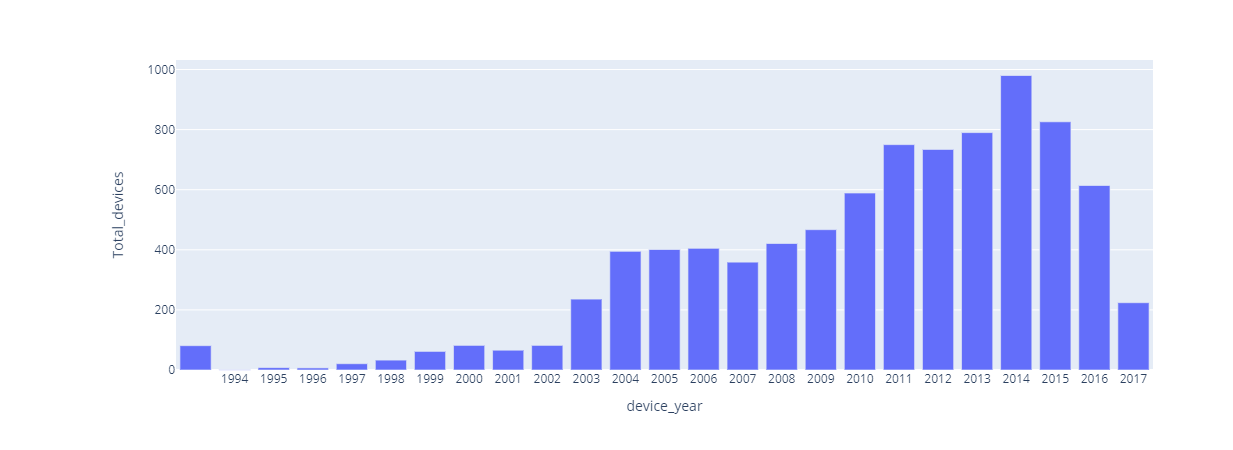

In [5]:
# Lista de años que buscaremos
years = ['2017','2016','2015','2014','2013','2012',
         '2011','2010','2009','2008','2007','2006',
         '2005', '2004', '2003','2002', '2001', '2000',
         '1999', '1998', '1997', '1996', '1995', '1994',
         'Discontinued', 'Cancelled', 'Available', '']

# Nueva columna de status para cuando contenga los valores 'Discontinued', 'Cancelled', 'Available', ''
df['new_status'] = np.where(df['Status'].isin(['Discontinued', 'Cancelled', 'Available', '']), df['Announced'], df['Status'])

# Lista donde almacenaremos los años
device_year=[]
# Bucle que recorerá cada valor de la columna new status y buscará si coincide con alguno de los años de la lista
for i in df['new_status'].values:
    for year in years:
        if (year == 'Discontinued') | (year == 'Cancelled') | (year == 'Available') | (year == ''):
            device_year.append('')
            break
        elif year in i:
            device_year.append(year)
            break

# Agregamos la nueva columna
df['device_year'] = device_year

# Hacemos el conteo de dispositivos por año
data = df[['device_year', 'Device_id']].groupby('device_year', as_index=False).count().sort_values('device_year').rename(columns={'Device_id':'Total_devices'})
fig = px.bar(data, x='device_year', y='Total_devices')
fig.show()

<a id="q2"></a>
### ¿Cuál fue la marca que más dispositivos saco al mercado en 2010?

In [6]:
temp = df[df['device_year']=='2010']
temp = temp[['Brand','Device_id']].groupby('Brand', as_index=False).count().sort_values('Device_id', ascending=False).rename(columns={'Device_id':'Total_devices'})
temp.head(1)

,Brand,Total_devices
24,Samsung,106


<a id="q3"></a>

### Top 5 marcas por número de dispositivos

In [7]:
temp = df[['Brand','Device_id']].groupby('Brand', as_index=False).count().sort_values('Device_id', ascending=False).rename(columns={'Device_id':'Total_devices'})
temp.head()

,Brand,Total_devices
76,Samsung,1105
42,LG,591
59,Nokia,446
55,Motorola,443
103,alcatel,360


<a id="q4"></a>
### ¿Dispositivo con más RAM?
La columna RAM viene especialmente sucia, ya que a veces contiene el dato de la ROM (almacenamiento del dispositivo), a veces contiene la RAM y la ROM separadas por un |, y otras veces vienen varias configuraciones de RAM.
Por tanto, para extraer el dispositivo con más memoria RAM hay que:

- Evitar contabilizar la ROM como memoria RAM
- Seleccionar la mayor de las configuraciones RAM
- Evitar otros problemas como que aparezca un número anormalmente elevado para una memoria RAM (Ejemplo una fila con el número 256 sin indicar si son kb, mb o gb)

In [8]:
# Lo primero que vamos a hacer es separar la columna RAM en varias si contiene el delimitador |
# Esto se debe a que un dispositivo puede tener diferentes configuraciones de RAM (normalmente hasta 3)
df['RAM2'] =  df['RAM'].str.split('|').str[-1]
df['RAM3'] =  df['RAM2'].str.split('|').str[-1]

# Lista donde almacenaremos la ram de cada dispositivo
device_ram1=[]
device_ram2=[]
device_ram3=[]
list_new_col_ram = [device_ram1, device_ram2, device_ram3]
list_col_ram = ['RAM','RAM2','RAM3']
# Bucle que recorerá cada valor de la columna ram e intentará extraer la cantidad de RAM descartando la ROM
for col_ram, new_col_ram  in zip(list_col_ram, list_new_col_ram):
    for i in df[col_ram].values:
        if ('ROM' in i) & ('RAM' in i):
            pos_ram = i.find('RAM') - 1
            pos_rom = i.find('ROM') - 1
            if pos_ram < pos_rom:
                new_col_ram.append(i[:pos_ram])
            elif pos_ram > pos_rom:
                pos_rom_2 = i.find('ROM') + 4
                new_col_ram.append(i[pos_rom_2:pos_ram])
            else:
                new_col_ram.append(i)
        elif ('RAM' in i):
            pos_ram = i.find('RAM') - 1
            new_col_ram.append(i[:pos_ram])
        else:
            new_col_ram.append('')

# Generamos las tres nuevas columnas de RAM
df['device_ram1'] = device_ram1
df['device_ram2'] = device_ram2
df['device_ram3'] = device_ram3

In [9]:
# Ahora que ya hemos limpiado los casos que contiene ROM  y los dispositivos con varias configuraciones.
# Vamos a extraer el número de las filas que contengan GB y nos quedaremos con el máximo de las tres columnas.

temp = df[(df['device_ram1'].str.contains('GB')) | (df['device_ram2'].str.contains('GB')) | (df['device_ram3'].str.contains('GB'))]

# Función para extraer el mayor número de una string
def findLargestNumber(text):
    ls = list()
    for w in text.split():
        try:
            ls.append(int(w))
        except:
            pass
    try:
        return max(ls)
    except:
        return 0

# Listas donde almacenaremos el número de gb
device_ram_gb_number_1 = []
device_ram_gb_number_2 = []
device_ram_gb_number_3 = []
list_device_gb_number = [device_ram_gb_number_1, device_ram_gb_number_2, device_ram_gb_number_3]

# Lista de columnas que queremos recorrer
list_col_device_ram = ['device_ram1','device_ram2','device_ram3']

# Bucle que extraer el máximo número entero de cada columna
for device_ram, device_number_ram in zip(list_col_device_ram, list_device_gb_number):
    for i in temp[device_ram].values:
        num = findLargestNumber(i)
        if num > 9:
            device_number_ram.append(None)
        else:
            device_number_ram.append(findLargestNumber(i))


temp['device_ram_gb_number1'] = device_ram_gb_number_1
temp['device_ram_gb_number2'] = device_ram_gb_number_2
temp['device_ram_gb_number3'] = device_ram_gb_number_3
temp['RAM_GB'] = temp[['device_ram_gb_number1', 'device_ram_gb_number2', 'device_ram_gb_number3']].max(axis=1)
# temp.sort_values('device_ram_gb_number', ascending=False)[['Brand','Model','device_year','RAM','device_ram_gb_number']].head(10)

<ipython-input-9-ec9db5ed488a>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-ec9db5ed488a>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-ec9db5ed488a>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-ec9db5ed488

In [10]:
temp[['Brand', 'Model', 'RAM','device_ram1','device_ram2','device_ram3','RAM_GB']].sort_values('RAM_GB', ascending=False).head()

,Brand,Model,RAM,device_ram1,device_ram2,device_ram3,RAM_GB
2,OnePlus,_5,6 GB RAM or 128 GB| 8 GB RAM,6 GB,8 GB,8 GB,8.0
5272,ZTE,_nubia Z17,6 GB RAM or 128 GB| 8 GB RAM,6 GB,8 GB,8 GB,8.0
6237,Oppo,_R9s Plus,6 GB RAM,6 GB,6 GB,6 GB,6.0
1871,Coolpad,_Cool S1,4 GB RAM or 128 GB| 6 GB RAM,4 GB,6 GB,6 GB,6.0
1202,ZTE,_Axon 7s,6 GB RAM,6 GB,6 GB,6 GB,6.0
